# Emittance minimization using Xopt with BAXGenerator running algorithm ScipyMinimizeEmittance
In this notebook we demonstrate the use of Xopt to perform Bayesian Algorithm Execution (BAX) as a means of minimizing the emittance described by a simple optical beam size model. BAX is a generalization of Bayesian Optimization that seeks to acquire observations that provide our model with maximal information about our property of interest. In this example, our property of interest is the minimal emittance and its location in tuning-parameter-space. See https://arxiv.org/pdf/2209.04587.pdf for details.

# Imports

In [1]:
# Ignore all warnings
import warnings
# warnings.filterwarnings("ignore")

import sys
# sys.path.append('C:\\Users\\Dylan\\SLAC') #parent directory containing emitopt module

import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator

from xopt.evaluator import Evaluator

from emitopt.analysis import compute_emit_bmag
from emitopt.sampling import draw_product_kernel_post_paths
from emitopt.algorithms import GridMinimizeEmitBmag

import time
import numpy as np
import random

# Use CUDA if available

In [2]:
if torch.cuda.is_available():
# if False:
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
    tkwargs = {"dtype": torch.double, "device": "cuda"}
    use_cuda = True
    print('Using cuda.')
else:
    torch.set_default_tensor_type('torch.DoubleTensor')
    use_cuda = False

C:\Users\Dylan\AppData\Roaming\Python\Python39\site-packages\torch\__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [3]:
torch.cuda.is_available()

False

# Notebook settings

In [4]:
ndim = 3 #number of input dimensions
noise = False #whether to add noise to the ground-truth beam size function outputs
thick_quad = False
meas_dim = 1 #input dimension for measurement parameter
n_obs_init = 50 #number of random initial observations for GP model
n_samples = 20 #number of posterior samples for BAX
n_iter = 50 #number of optimization steps for Xopt to take (after acquiring random initial data)
rand_seed = 3

#random seeds for reproducibility 
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) #only affects initial random observations through Xopt
random.seed(rand_seed)

# Build test function from single-quadrupole optical beam size model 
Here we define a simple ground-truth beam size function for our optimization problem, where we attempt to find the location in tuning parameter space with minimal emittance. Note that the function "test_func" used to evaluate the ground-truth beam size function takes a dictionary as input and returns a dictionary as the output.

In [5]:
from pyemittance.emittance_calc import EmitCalc
from pyemittance.load_json_configs import load_configs
from pyemittance.simulation import BeamSim

CONFIG = load_configs('LCLS2_OTR0H04')
CONFIG['beamline_info']

q_len = CONFIG['beamline_info']['Lquad']
rmat_x = torch.tensor(CONFIG['beamline_info']['rMatx']).reshape(2,2)
rmat_y = torch.tensor(CONFIG['beamline_info']['rMaty']).reshape(2,2)
print(rmat_x)
print(rmat_y)

tensor([[1.0000, 2.2000],
        [0.0000, 1.0000]])
tensor([[1.0000, 2.2000],
        [0.0000, 1.0000]])


In [6]:
BUNCH_PARAMS0 = {
    'total_charge': 50e-12,
    'norm_emit_x': 1e-6,
    'norm_emit_y': 2e-6,
    'beta_x': 10,
    'alpha_x': -1,
    'beta_y': 11,
    'alpha_y': -2,
    'energy': 80e6,
    'species':'electron'
}
sim = BeamSim(bunch_params=BUNCH_PARAMS0, beamline_info=CONFIG['beamline_info'])


# define variables functions
var_names = ['x' + str(i) for i in range(ndim)]
meas_param = var_names[meas_dim]

scale = 1.e3
def measure_beamsize(input_dict):
    x_tuning = torch.tensor([])
    for key in input_dict.keys():
        if key is not meas_param:
            x_tuning = torch.cat((x_tuning, torch.tensor([input_dict[key]])))
    rms_beamsizes0 = np.array(sim.beam_size_meas(input_dict[meas_param]))
    detuning_scale = 1. + 1*x_tuning.abs().sum().cpu()
    xrms, yrms = detuning_scale * rms_beamsizes0
    return {'xrms_sq': (float(xrms)*scale)**2.,
            'yrms_sq': (float(yrms)*scale)**2.} # mean-square beam sizes in mm squared

from emitopt.utils import get_quad_scale_factor
scale_factor = get_quad_scale_factor(E=.08, q_len=q_len)
# scale_factor = 1.
q = torch.linspace(-3,3,20)
bs = torch.tensor([np.array(sim.beam_size_meas(v))*scale for v in q.numpy()]).T
print(bs)
k = scale_factor*q
ks = torch.stack((k,-k))
rmats = torch.stack((rmat_x, rmat_y))
emit, bmag, sig, is_valid = compute_emit_bmag(ks, bs**2, q_len, rmats, thick=True)
print(emit[0], emit[1])
gt_emit_min = (emit[0]*emit[1]).sqrt()
def ground_truth_geometric_mean_emittance(emit_min, x_tuning):
    detuning_scale = 1. + x_tuning.abs().sum(dim=1)
    emit = emit_min * detuning_scale**2
    return emit

print('Ground truth minimum emit:', gt_emit_min)

tensor([[0.9752, 0.9042, 0.8337, 0.7634, 0.6936, 0.6241, 0.5550, 0.4864, 0.4182,
         0.3506, 0.2836, 0.2176, 0.1536, 0.0946, 0.0575, 0.0809, 0.1362, 0.1979,
         0.2613, 0.3252],
        [0.4155, 0.3205, 0.2269, 0.1385, 0.0781, 0.1120, 0.1969, 0.2917, 0.3896,
         0.4890, 0.5895, 0.6907, 0.7926, 0.8952, 0.9983, 1.1019, 1.2061, 1.3109,
         1.4161, 1.5219]])
tensor(0.0064) tensor(0.0128)
Ground truth minimum emit: tensor(0.0090)


C:\Users\Dylan\AppData\Local\Temp\ipykernel_4320\553575912.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  bs = torch.tensor([np.array(sim.beam_size_meas(v))*scale for v in q.numpy()]).T


# Construct vocs

In [7]:
variables = {var_name: [-2,1] for var_name in var_names}
variables[meas_param] = [-3,3] #overwrite bounds for measurement parameter to capture minimum of single-quadrupole optical model

#construct vocs
vocs = VOCS(
    variables = variables,
    observables = ['xrms_sq', 'yrms_sq'],
)

print('variable_names =', vocs.variable_names)
print('meas_param =', "'" + meas_param + "'")
print('domain =\n', vocs.bounds.T)

variable_names = ['x0', 'x1', 'x2']
meas_param = 'x1'
domain =
 [[-2.  1.]
 [-3.  3.]
 [-2.  1.]]


# Prepare generator options.
In this example, we use a specialty covariance module (Matern x Quadratic kernel) for our beam size model.

In [8]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt.generators.bayesian.bax_generator import BaxGenerator
from emitopt.algorithms import ScipyMinimizeEmittanceXY

# prepare custom covariance module
tuning_dims = list(range(vocs.n_variables))
tuning_dims.remove(meas_dim)
covar_module_x = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )

scaled_covar_module_x = ScaleKernel(covar_module_x)#, outputscale_prior=GammaPrior(2.0, 0.15))
covar_module_y = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )
scaled_covar_module_y =  ScaleKernel(covar_module_y)#, outputscale_prior=GammaPrior(2.0, 0.15))

# prepare options for Xopt generator
covar_module_dict = {'xrms_sq': scaled_covar_module_x,
                     'yrms_sq': scaled_covar_module_y}

model_constructor = StandardModelConstructor(covar_modules=covar_module_dict, use_low_noise_prior=True)

In [9]:
from xopt.numerical_optimizer import LBFGSOptimizer, GridOptimizer
numerical_optimizer = LBFGSOptimizer(
                                    n_restarts=20,
                                    max_time=2)
# numerical_optimizer = GridOptimizer()

# Construct generator, evaluator, Xopt objects

In [10]:
#Prepare Algorithm
algo_kwargs = {
        'x_key': 'xrms_sq',
        'y_key': 'yrms_sq',
        'scale_factor': scale_factor,
        'q_len': q_len,
        'rmat_x': rmat_x,
        'rmat_y': rmat_y,
        'twiss0_x': torch.tensor([10., -1.]),
        'twiss0_y': torch.tensor([11., -2.]),
        'n_samples': n_samples,
        'meas_dim': meas_dim,
        'n_steps_measurement_param': 20,
        'thick_quad': thick_quad,
        'n_grid_points': 15
}
algo = GridMinimizeEmitBmag(**algo_kwargs)
# algo = ScipyMinimizeEmittanceXY(**algo_kwargs)

#construct BAX generator
generator = BaxGenerator(vocs=vocs, 
                         gp_constructor=model_constructor, 
                         numerical_optimizer=numerical_optimizer,
                         algorithm=algo, 
                         use_cuda=use_cuda)

#construct evaluator
evaluator = Evaluator(function=measure_beamsize)

#construct Xopt optimizer
optimizer = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

# Optimize

In [11]:
# call X.random_evaluate() to generate random initial points and evaluate on test_func
optimizer.random_evaluate(n_obs_init)

,x0,x1,x2,xrms_sq,yrms_sq,xopt_runtime,xopt_error
0,-0.652394,1.767538,0.423783,0.031623,5.330613,0.010573,False
1,-1.124443,1.791728,-1.177009,0.087332,13.672858,0.000305,False
2,0.127286,-0.084210,-1.354810,0.690828,1.617473,0.000400,False
3,-0.532483,2.476624,-1.916295,0.573145,21.577236,0.000218,False
4,-1.678841,0.098487,-1.552914,1.570354,5.828868,0.000218,False
5,-1.688879,0.826943,-0.630783,0.235506,7.137364,0.000282,False
6,0.623244,-1.246120,0.730627,1.901417,0.136298,0.000226,False
7,0.378271,-1.480477,-0.466620,1.381805,0.033425,0.000211,False
8,0.845598,-1.146558,-1.783809,4.191015,0.450477,0.000207,False
9,-0.322430,-1.135082,-1.362855,2.273858,0.255493,0.000212,False


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


(<Figure size 800x990 with 11 Axes>,
 array([[<AxesSubplot: title={'center': 'Posterior Mean [xrms_sq]'}, ylabel='x1'>,
         <AxesSubplot: title={'center': 'Posterior SD [xrms_sq]'}>],
        [<AxesSubplot: title={'center': 'Posterior Mean [yrms_sq]'}, ylabel='x1'>,
         <AxesSubplot: title={'center': 'Posterior SD [yrms_sq]'}>],
        [<AxesSubplot: title={'center': 'Acq. Function'}, xlabel='x2', ylabel='x1'>,
         <AxesSubplot: xlabel='x2'>]], dtype=object))

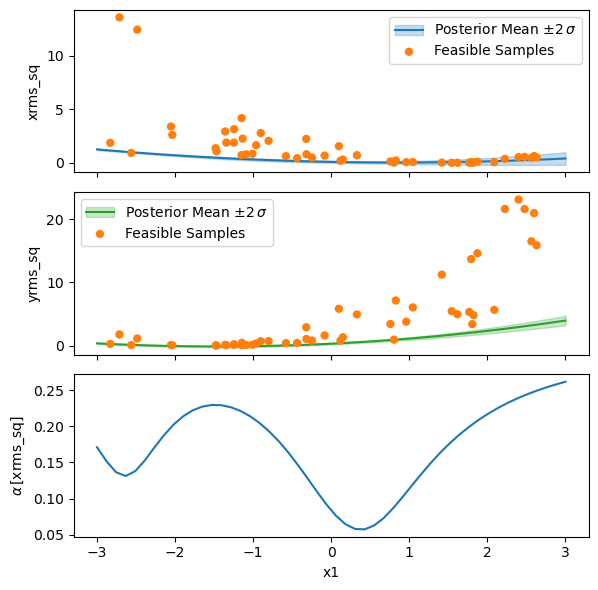

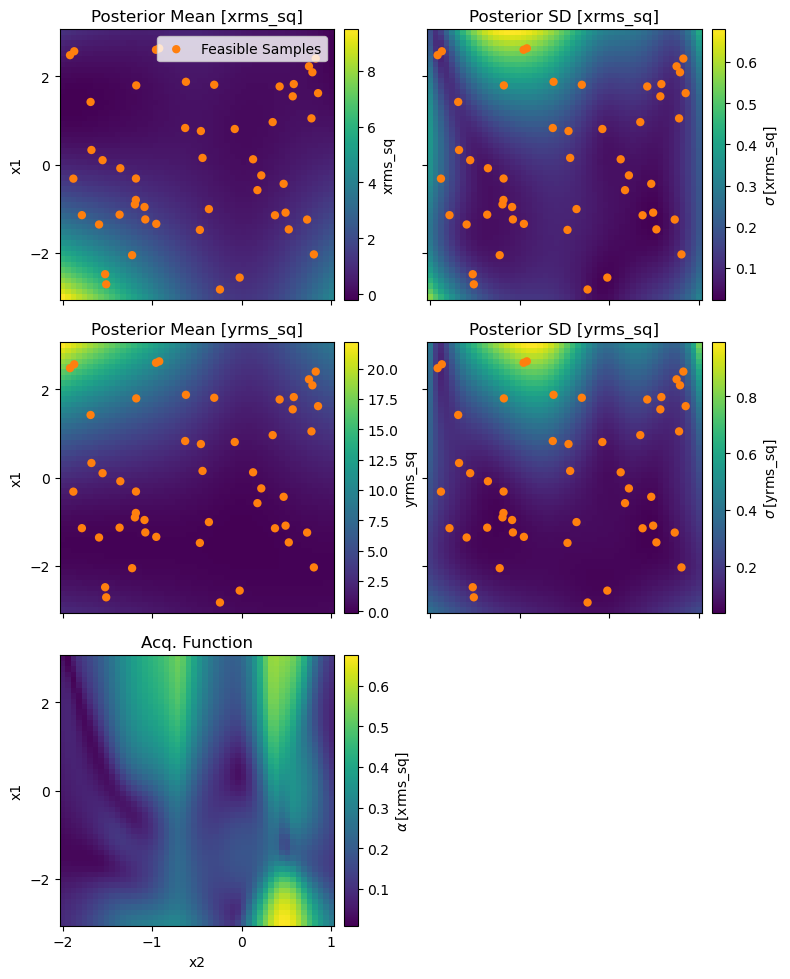

In [12]:
from xopt.generators.bayesian.visualize import visualize_generator_model
optimizer.generator.train_model()
visualize_generator_model(optimizer.generator, variable_names=['x1'], reference_point={'x0':torch.tensor([0.]), 'x2':torch.tensor([0.]), 'x3':torch.tensor([0.])})
visualize_generator_model(optimizer.generator, variable_names=['x2','x1'], reference_point={'x1':torch.tensor([0.]),'x2':torch.tensor([0.]), 'x0':torch.tensor([0.])})

C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


(<Figure size 800x370 with 4 Axes>,
 array([<AxesSubplot: title={'center': 'Objective Median'}, xlabel='x0', ylabel='x2'>,
        <AxesSubplot: title={'center': 'Objective SD'}, xlabel='x0', ylabel='x2'>],
       dtype=object))

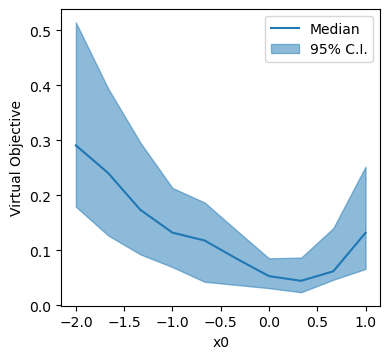

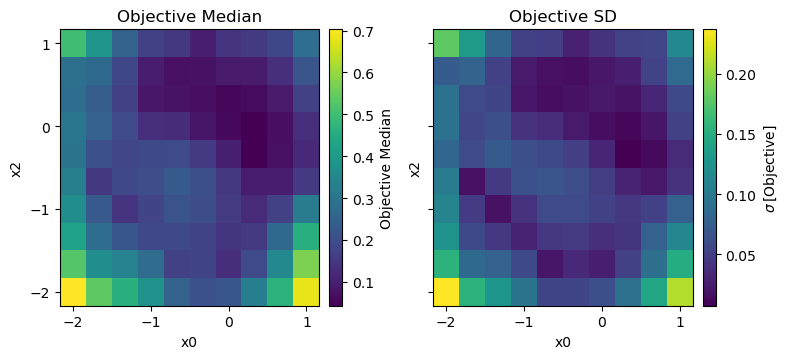

In [13]:
from xopt.generators.bayesian.bax.visualize import visualize_virtual_objective
visualize_virtual_objective(optimizer.generator, variable_names=['x0'],reference_point={'x0':torch.tensor([0.]), 'x1':torch.tensor([0.]), 'x2':torch.tensor([0.])}, n_grid=10, n_samples=1000)
visualize_virtual_objective(optimizer.generator, variable_names=['x0','x2'],reference_point={'x0':torch.tensor([0.]), 'x1':torch.tensor([0.]), 'x2':torch.tensor([0.])}, n_grid=10, n_samples=1000)

In [14]:
results = []

In [15]:
# plt.hist(emits_at_target_valid.flatten().cpu(), density=True)
# plt.xlabel('Predicted Optimal Emittance')
# plt.ylabel('Probability Density')
# plt.show()
# print('sample validity rate:', svr)

for i in range(1, n_iter+1):

    print('Iteration:', i, '/', n_iter)

    start = time.time()

    # call X.step() to generate a random initial point and evaluate on test_func
    optimizer.step()    

    
    #extract GP models
    model = optimizer.generator.train_model()
    bax_model_ids = [optimizer.generator.vocs.output_names.index(name)
                            for name in optimizer.generator.algorithm.observable_names_ordered]
    bax_model = model.subset_output(bax_model_ids)
    beam_size_model_x = bax_model.models[0]
    beam_size_model_y = bax_model.models[1]
    
    #extract and store algorithm results for this iteration
    results += [optimizer.generator.algorithm_results]
#     beam_size_models[i] = beam_size_model
    
    #get mean-predicted optimal tuning config and eval predicted emits at this location in tuning parameter space
    algo = optimizer.generator.algorithm
#     X_tuned, emits_at_target_valid, svr = algo.mean_output(beam_size_model,
#                                                          torch.tensor(vocs.bounds),
#                                                          num_restarts=10)
    
    end = time.time()
    print('This iteration took:', end-start, 'seconds.\n')

#     if i % 5 == 0:
#         plt.hist(emits_at_target_valid.flatten().cpu(), density=True)
#         plt.xlabel('Predicted Optimal Emittance')
#         plt.ylabel('Probability Density')
#         plt.show()
#         print('sample validity rate:', svr)

Iteration: 1 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 9.198112487792969 seconds.

Iteration: 2 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.809367895126343 seconds.

Iteration: 3 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 7.017186164855957 seconds.

Iteration: 4 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.682181119918823 seconds.

Iteration: 5 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.68347954750061 seconds.

Iteration: 6 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.737421035766602 seconds.

Iteration: 7 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.492564678192139 seconds.

Iteration: 8 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.854231834411621 seconds.

Iteration: 9 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.833045721054077 seconds.

Iteration: 10 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.831234931945801 seconds.

Iteration: 11 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.5765135288238525 seconds.

Iteration: 12 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.795823812484741 seconds.

Iteration: 13 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.711884021759033 seconds.

Iteration: 14 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.6928486824035645 seconds.

Iteration: 15 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.891096830368042 seconds.

Iteration: 16 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.608568906784058 seconds.

Iteration: 17 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.974223375320435 seconds.

Iteration: 18 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.989384889602661 seconds.

Iteration: 19 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.848272085189819 seconds.

Iteration: 20 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.758343458175659 seconds.

Iteration: 21 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.529166221618652 seconds.

Iteration: 22 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 7.279209613800049 seconds.

Iteration: 23 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.966740369796753 seconds.

Iteration: 24 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.95487642288208 seconds.

Iteration: 25 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.984904766082764 seconds.

Iteration: 26 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.677924633026123 seconds.

Iteration: 27 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.9534547328948975 seconds.

Iteration: 28 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 7.002219915390015 seconds.

Iteration: 29 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.902868986129761 seconds.

Iteration: 30 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.737372159957886 seconds.

Iteration: 31 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.920697927474976 seconds.

Iteration: 32 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.888849258422852 seconds.

Iteration: 33 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 7.169438600540161 seconds.

Iteration: 34 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 7.051411151885986 seconds.

Iteration: 35 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.7171852588653564 seconds.

Iteration: 36 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 7.167658805847168 seconds.

Iteration: 37 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.69183087348938 seconds.

Iteration: 38 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.8752570152282715 seconds.

Iteration: 39 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.759308576583862 seconds.

Iteration: 40 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.793176174163818 seconds.

Iteration: 41 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.8996031284332275 seconds.

Iteration: 42 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.836984395980835 seconds.

Iteration: 43 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 7.194249629974365 seconds.

Iteration: 44 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.948976516723633 seconds.

Iteration: 45 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.962899446487427 seconds.

Iteration: 46 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.569899797439575 seconds.

Iteration: 47 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 6.983609914779663 seconds.

Iteration: 48 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 7.101060390472412 seconds.

Iteration: 49 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 7.337651252746582 seconds.

Iteration: 50 / 50


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


This iteration took: 7.599217653274536 seconds.



C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


(<Figure size 800x370 with 4 Axes>,
 array([<AxesSubplot: title={'center': 'Objective Median'}, xlabel='x0', ylabel='x2'>,
        <AxesSubplot: title={'center': 'Objective SD'}, xlabel='x0', ylabel='x2'>],
       dtype=object))

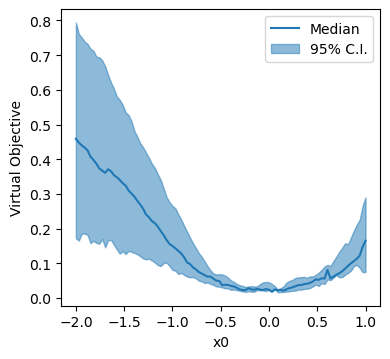

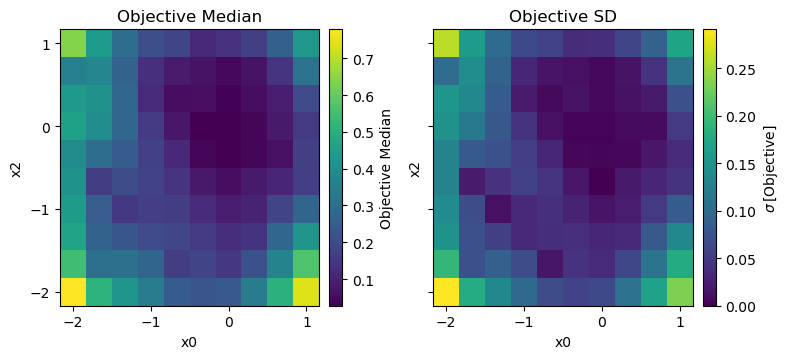

In [16]:
optimizer.generator.train_model()
# visualize_generator_model(optimizer.generator, variable_names=['x1'], reference_point={'x0':torch.tensor([0.]), 'x2':torch.tensor([0.])})
# visualize_generator_model(optimizer.generator, variable_names=['x0','x1'], reference_point={'x2':torch.tensor([0.])})
visualize_virtual_objective(optimizer.generator, variable_names=['x0'],reference_point={'x0':torch.tensor([0.]), 'x1':torch.tensor([0.]), 'x2':torch.tensor([0.])}, n_grid=100, n_samples=1000)
visualize_virtual_objective(optimizer.generator, variable_names=['x0','x2'],reference_point={'x0':torch.tensor([0.]), 'x1':torch.tensor([0.]), 'x2':torch.tensor([0.])}, n_grid=10, n_samples=1000)

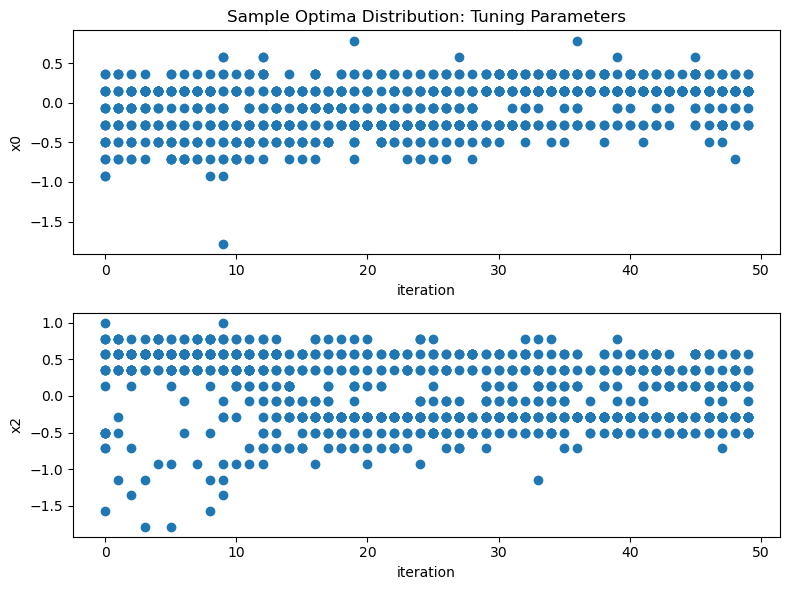

In [17]:
from emitopt.visualize import plot_sample_optima_convergence_inputs
fig, axs = plot_sample_optima_convergence_inputs(optimizer.generator, results, show_valid_only=False)
# for ax in axs:
#     ax.axhline(0, ls='--', c='k')

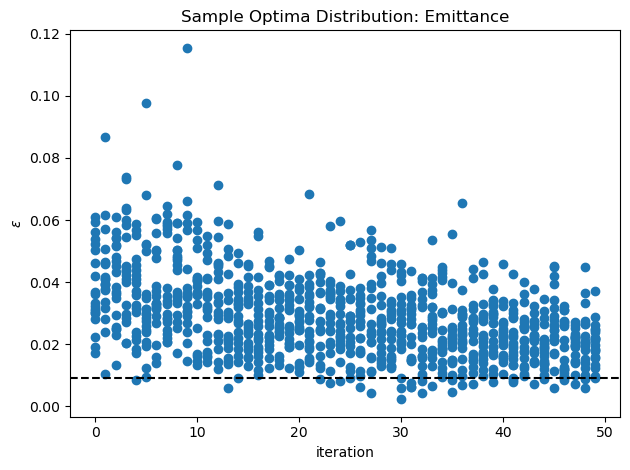

In [18]:
from emitopt.visualize import plot_sample_optima_convergence_emits
fig, ax = plot_sample_optima_convergence_emits(results)
ax.axhline(gt_emit_min, ls='--', c='k', label='ground truth')

In [19]:
from emitopt.utils import x_tuning_to_dict, get_bax_optimum
print(optimizer.generator.algorithm_results['x_tuning_best'])
x_tuning_best = optimizer.generator.algorithm_results['x_tuning_best'].mean(dim=0)
print(x_tuning_best)
reference_point = get_bax_optimum(optimizer.generator)
print(reference_point)
target_point = x_tuning_to_dict(optimizer.generator, x_tuning = torch.tensor([[0,0]]))
print(target_point)

tensor([[[ 0.1429, -0.5000]],

        [[ 0.1429,  0.1429]],

        [[-0.0714,  0.3571]],

        [[ 0.1429, -0.5000]],

        [[-0.2857,  0.1429]],

        [[ 0.3571, -0.2857]],

        [[ 0.1429, -0.2857]],

        [[ 0.1429, -0.5000]],

        [[ 0.1429, -0.2857]],

        [[ 0.1429, -0.2857]],

        [[-0.2857, -0.0714]],

        [[ 0.1429, -0.5000]],

        [[ 0.1429,  0.1429]],

        [[ 0.1429, -0.2857]],

        [[ 0.1429, -0.5000]],

        [[ 0.1429, -0.2857]],

        [[-0.2857,  0.5714]],

        [[ 0.1429, -0.2857]],

        [[ 0.3571, -0.2857]],

        [[ 0.1429, -0.2857]]])
tensor([[ 0.0893, -0.1893]])
{'x0': 0.0892817857142858, 'x2': -0.18928778571428562}
{'x0': 0.0, 'x2': 0.0}


Lowest bmag found at measurement quad value: tensor(-3.)


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


(-0.38080117240569056, 10.0)

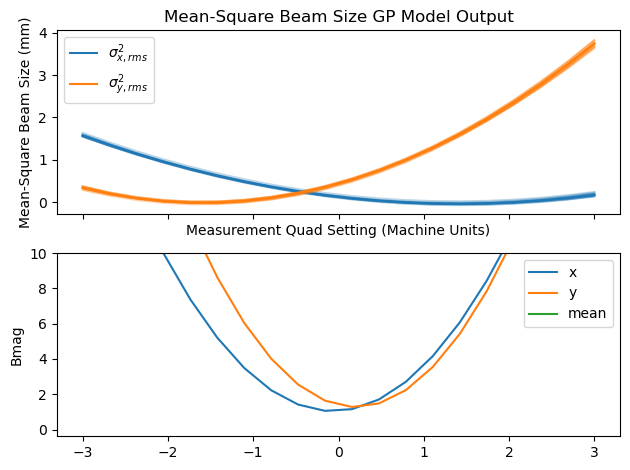

In [29]:
from emitopt.visualize import plot_virtual_measurement_scan
fig, ax, best_q = plot_virtual_measurement_scan(optimizer, reference_point, n_samples=10)
ax[1].set_ylim(top=10)

get_acquisition took 3.974954128265381 seconds.
optimize_acqf took 2.342385768890381 seconds.


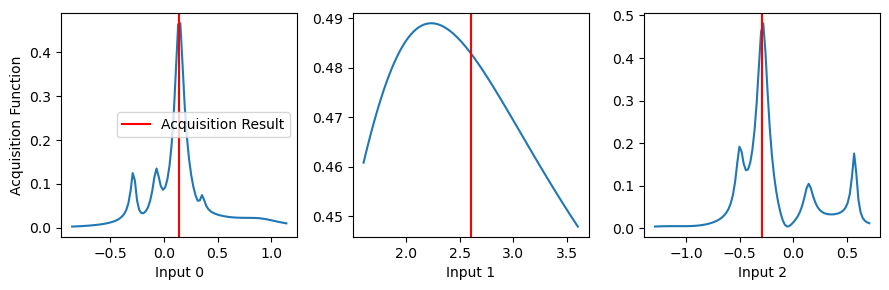

In [24]:
from emitopt.visualize import plot_acq_func_opt_results
plot_acq_func_opt_results(optimizer)